# Examples using `BlackMarblePy`

This Jupyter notebook provides a guided exploration of the [**BlackMarblePy**](https://pypi.org/project/blackmarblepy/) package, showcasing its capabilities for downloading, visualizing, and analyzing NASA Black Marble nighttime lights data. Through interactive examples, you'll learn how to:

- Download daily, monthly, and yearly data for specific dates, regions, or bounding boxes.
- Visualize downloaded data in various forms, including maps and  bar charts.
- Save visualizations and analysis results for further use.

## Requirements

In this example, we use additional dependencies included below below for convenience. However, it is strongly recommended to install requirements on a [virtual environment](https://docs.python.org/3/library/venv.html).

In [1]:
# pip install blackmarblepy
#!pip install colorcet contextily geopandas matplotlib seaborn pandas folium mapclassify

In [2]:
import os

import colorcet as cc
import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from blackmarble.extract import bm_extract
from blackmarble.raster import bm_raster

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (18, 10)

### Generate NASA Earthdata Token

**BlackMarblePy** requires a [NASA Earthdata](https://urs.earthdata.nasa.gov) **bearer token**. To generate a token, you may use [Earthdata Login](https://urs.earthdata.nasa.gov/documentation)

1. Access [Earthdata Login](https://urs.earthdata.nasa.gov/profile). In case you haven't already, you must [register](https://urs.earthdata.nasa.gov/users/new).
    ```{figure} ../images/nasa_earthdata_profile.png
    ---
    height: 150px
    ---
2. Select **Generate Token**. If the token is expired or you are in need of one, click the **Generate Token** button. 
    ```{figure} ../images/nasa_earthdata_generate_token.png
    ---
    height: 400px
    ---
3. Copy and use the token securely with [BlackMarblePy](https://worldbank.github.io/blackmarblepy/api/blackmarble.html)
    ```python
    import os

    bearer = os.getenv("BLACKMARBLE_TOKEN")
    ```

In [3]:
bearer = os.getenv("BLACKMARBLE_TOKEN")


```{important}
Using a secret token securely in Python code involves several practices to ensure the token is not exposed unintentionally. For instance, storing the secret token in an environment variable, in configuration files or using secret management services. In this example, we set up an environment variable.
```

```{seealso}
- [Using Secrets Securely](https://worldbank.github.io/template/notebooks/nasa-apod.html)
- [Best Practices for Securing API Keys](https://rapidapi.com/guides/practices-api-keys)
```

### Define Region of Interest

Define region of interest for which we will download nighttime lights data. We obtain the polygon from [GADM](https://gadm.org/download_country.html).

In [4]:
gdf = geopandas.read_file(
    "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_GHA_1.json.zip"
)
gdf.explore()

## Examples

In this section, we will demonstrate how to use [blackmarblepy](https://pypi.org/project/blackmarblepy/) to download and manipulate NASA Black Marble data. 

### Create raster of nighttime lights

In this section, we show examples of creating daily, monthly, and annual rasters of nighttime lights for the **Region of Interest** selected.


#### Daily

In [5]:
# Daily data: raster for February 5, 2021
r_20210205 = bm_raster(
    gdf, product_id="VNP46A2", date_range="2021-02-05", bearer=bearer
)

GETTING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

  0%|          | 0.00/3.26M [00:00<?, ?B/s]

  0%|          | 0.00/3.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.41M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
r_20210205

<xarray.Dataset>
Dimensions:                            (x: 1071, y: 1544, time: 1)
Coordinates:
  * x                                  (x) float64 -3.26 -3.256 ... 1.194 1.198
  * y                                  (y) float64 11.17 11.17 ... 4.748 4.744
  * time                               (time) datetime64[ns] 2021-02-05
Data variables:
    Gap_Filled_DNB_BRDF-Corrected_NTL  (time, y, x) float64 nan nan ... nan nan
Attributes: (12/41)
    AlgorithmType:                     b'SCI'
    AREA_OR_POINT:                     Area
    DataResolution:                    b'Moderate'
    DayNightFlag:                      b'Day'
    EastBoundingCoord:                 0.0
    EndTime:                           b'2021-02-05 23:59:59.000'
    ...                                ...
    TileID:                            b'61017008'
    VersionID:                         b'001'
    VerticalTileNumber:                b'08'
    WestBoundingCoord:                 -10.0
    scale_factor:                      1.0
    add_offset:                        0.0

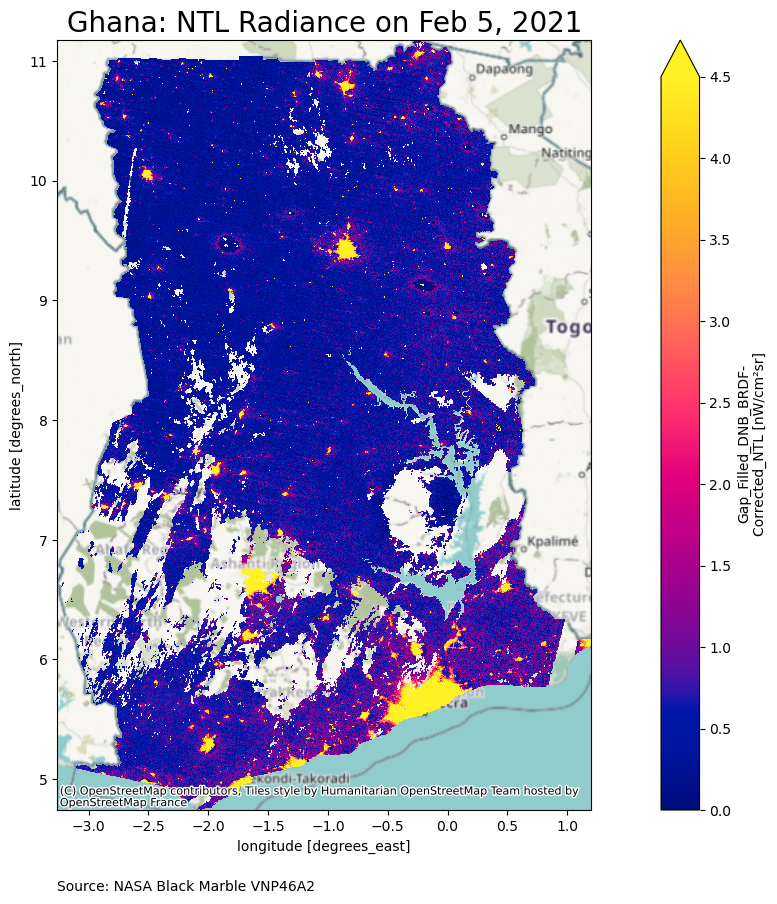

In [7]:
fig, ax = plt.subplots()

r_20210205["Gap_Filled_DNB_BRDF-Corrected_NTL"].sel(time="2021-02-05").plot.pcolormesh(
    ax=ax,
    cmap=cc.cm.bmy,
    robust=True,
)
cx.add_basemap(ax, crs=gdf.crs.to_string())

ax.text(
    0,
    -0.1,
    "Source: NASA Black Marble VNP46A2",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance on Feb 5, 2021", fontsize=20);

#### Monthly

In [8]:
# Monthly data: raster for October 2021
r_202110 = bm_raster(gdf, product_id="VNP46A3", date_range="2021-10-01", bearer=bearer)

GETTING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0.00/8.64M [00:00<?, ?B/s]

  0%|          | 0.00/10.6M [00:00<?, ?B/s]

  0%|          | 0.00/11.5M [00:00<?, ?B/s]

  0%|          | 0.00/7.72M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

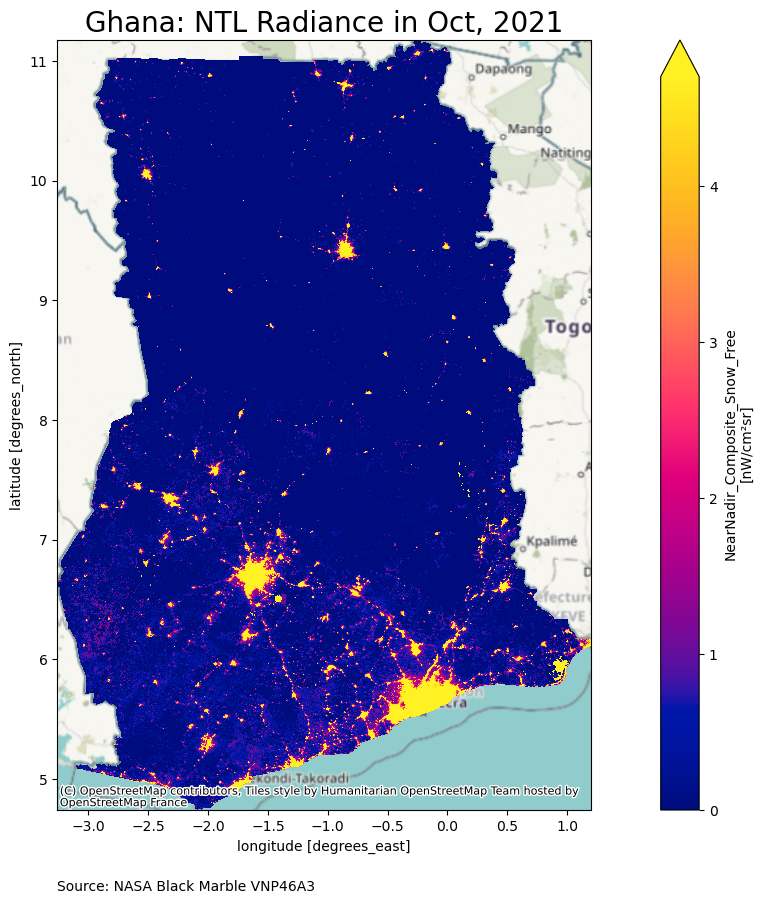

In [9]:
fig, ax = plt.subplots()

r_202110["NearNadir_Composite_Snow_Free"].sel(time="2021-10-01").plot.pcolormesh(
    ax=ax,
    cmap=cc.cm.bmy,
    robust=True,
)
cx.add_basemap(ax, crs=gdf.crs.to_string())

ax.text(
    0,
    -0.1,
    "Source: NASA Black Marble VNP46A3",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance in Oct, 2021", fontsize=20);

#### Annual

In [10]:
### Annual data: raster for 2021
r_2021 = bm_raster(gdf, product_id="VNP46A4", date_range="2021-01-01", bearer=bearer)

GETTING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0.00/13.8M [00:00<?, ?B/s]

  0%|          | 0.00/9.37M [00:00<?, ?B/s]

  0%|          | 0.00/14.0M [00:00<?, ?B/s]

  0%|          | 0.00/9.66M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/4 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

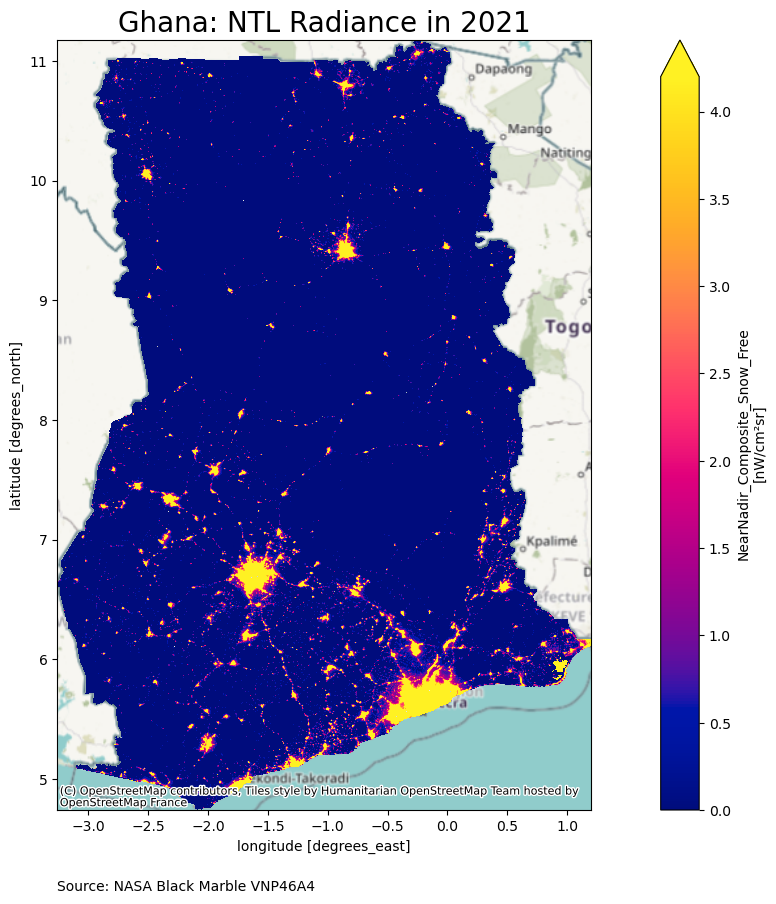

In [11]:
fig, ax = plt.subplots()

r_2021["NearNadir_Composite_Snow_Free"].sel(time="2021-01-01").plot.pcolormesh(
    ax=ax,
    cmap=cc.cm.bmy,
    robust=True,
)
cx.add_basemap(ax, crs=gdf.crs.to_string())

ax.text(
    0,
    -0.1,
    "Source: NASA Black Marble VNP46A4",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance in 2021", fontsize=20);

### Create a raster stack of nighttime lights across multiple time periods

In this section, we illustrate how to retrieve and extract [NASA Black Marble](https://blackmarble.gsfc.nasa.gov) data for multiple time periods. The function will return a raster stack, where each raster band corresponds to a different date. The following code snippet provides examples of getting data across multiple days, months, and years. For each example, we define a date range using [`pd.date_range`](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html).

In [ ]:
#### Raster stack of daily data
date_range = pd.date_range("2022-01-01", "2022-03-31", freq="D")

r_daily = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range=date_range,
    bearer=bearer,
)

GETTING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/360 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0.00/1.87M [00:00<?, ?B/s]

  0%|          | 0.00/1.50M [00:00<?, ?B/s]

  0%|          | 0.00/2.12M [00:00<?, ?B/s]

  0%|          | 0.00/2.78M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/2.62M [00:00<?, ?B/s]

  0%|          | 0.00/2.15M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/3.01M [00:00<?, ?B/s]

  0%|          | 0.00/2.74M [00:00<?, ?B/s]

  0%|          | 0.00/1.86M [00:00<?, ?B/s]

  0%|          | 0.00/2.33M [00:00<?, ?B/s]

  0%|          | 0.00/1.67M [00:00<?, ?B/s]

  0%|          | 0.00/3.54M [00:00<?, ?B/s]

  0%|          | 0.00/2.25M [00:00<?, ?B/s]

  0%|          | 0.00/2.48M [00:00<?, ?B/s]

  0%|          | 0.00/2.44M [00:00<?, ?B/s]

  0%|          | 0.00/2.90M [00:00<?, ?B/s]

  0%|          | 0.00/2.58M [00:00<?, ?B/s]

  0%|          | 0.00/1.39M [00:00<?, ?B/s]

  0%|          | 0.00/3.51M [00:00<?, ?B/s]

  0%|          | 0.00/3.66M [00:00<?, ?B/s]

  0%|          | 0.00/3.17M [00:00<?, ?B/s]

  0%|          | 0.00/2.84M [00:00<?, ?B/s]

  0%|          | 0.00/2.72M [00:00<?, ?B/s]

  0%|          | 0.00/3.36M [00:00<?, ?B/s]

  0%|          | 0.00/3.00M [00:00<?, ?B/s]

  0%|          | 0.00/2.34M [00:00<?, ?B/s]

  0%|          | 0.00/2.76M [00:00<?, ?B/s]

  0%|          | 0.00/3.03M [00:00<?, ?B/s]

  0%|          | 0.00/2.81M [00:00<?, ?B/s]

  0%|          | 0.00/2.43M [00:00<?, ?B/s]

  0%|          | 0.00/2.48M [00:00<?, ?B/s]

  0%|          | 0.00/2.88M [00:00<?, ?B/s]

  0%|          | 0.00/2.74M [00:00<?, ?B/s]

  0%|          | 0.00/2.56M [00:00<?, ?B/s]

  0%|          | 0.00/1.97M [00:00<?, ?B/s]

  0%|          | 0.00/2.78M [00:00<?, ?B/s]

  0%|          | 0.00/2.74M [00:00<?, ?B/s]

  0%|          | 0.00/1.84M [00:00<?, ?B/s]

  0%|          | 0.00/2.55M [00:00<?, ?B/s]

  0%|          | 0.00/1.90M [00:00<?, ?B/s]

  0%|          | 0.00/3.18M [00:00<?, ?B/s]

  0%|          | 0.00/3.89M [00:00<?, ?B/s]

  0%|          | 0.00/3.71M [00:00<?, ?B/s]

  0%|          | 0.00/3.40M [00:00<?, ?B/s]

  0%|          | 0.00/2.57M [00:00<?, ?B/s]

  0%|          | 0.00/1.46M [00:00<?, ?B/s]

  0%|          | 0.00/2.54M [00:00<?, ?B/s]

  0%|          | 0.00/2.75M [00:00<?, ?B/s]

  0%|          | 0.00/2.79M [00:00<?, ?B/s]

  0%|          | 0.00/2.61M [00:00<?, ?B/s]

  0%|          | 0.00/3.48M [00:00<?, ?B/s]

  0%|          | 0.00/2.90M [00:00<?, ?B/s]

  0%|          | 0.00/2.69M [00:00<?, ?B/s]

  0%|          | 0.00/3.51M [00:00<?, ?B/s]

  0%|          | 0.00/2.53M [00:00<?, ?B/s]

  0%|          | 0.00/2.15M [00:00<?, ?B/s]

  0%|          | 0.00/1.81M [00:00<?, ?B/s]

  0%|          | 0.00/1.71M [00:00<?, ?B/s]

  0%|          | 0.00/2.31M [00:00<?, ?B/s]

  0%|          | 0.00/1.65M [00:00<?, ?B/s]

  0%|          | 0.00/2.28M [00:00<?, ?B/s]

  0%|          | 0.00/2.45M [00:00<?, ?B/s]

  0%|          | 0.00/2.17M [00:00<?, ?B/s]

  0%|          | 0.00/2.38M [00:00<?, ?B/s]

  0%|          | 0.00/2.04M [00:00<?, ?B/s]

  0%|          | 0.00/1.73M [00:00<?, ?B/s]

  0%|          | 0.00/1.73M [00:00<?, ?B/s]

  0%|          | 0.00/2.33M [00:00<?, ?B/s]

  0%|          | 0.00/2.11M [00:00<?, ?B/s]

  0%|          | 0.00/1.70M [00:00<?, ?B/s]

  0%|          | 0.00/1.19M [00:00<?, ?B/s]

  0%|          | 0.00/1.59M [00:00<?, ?B/s]

  0%|          | 0.00/2.87M [00:00<?, ?B/s]

  0%|          | 0.00/1.49M [00:00<?, ?B/s]

  0%|          | 0.00/2.18M [00:00<?, ?B/s]

  0%|          | 0.00/1.40M [00:00<?, ?B/s]

  0%|          | 0.00/2.29M [00:00<?, ?B/s]

  0%|          | 0.00/2.16M [00:00<?, ?B/s]

  0%|          | 0.00/1.93M [00:00<?, ?B/s]

  0%|          | 0.00/3.04M [00:00<?, ?B/s]

  0%|          | 0.00/1.19M [00:00<?, ?B/s]

  0%|          | 0.00/1.51M [00:00<?, ?B/s]

  0%|          | 0.00/2.18M [00:00<?, ?B/s]

  0%|          | 0.00/1.48M [00:00<?, ?B/s]

  0%|          | 0.00/3.23M [00:00<?, ?B/s]

  0%|          | 0.00/2.10M [00:00<?, ?B/s]

  0%|          | 0.00/3.94M [00:00<?, ?B/s]

  0%|          | 0.00/2.19M [00:00<?, ?B/s]

  0%|          | 0.00/2.39M [00:00<?, ?B/s]

  0%|          | 0.00/1.99M [00:00<?, ?B/s]

  0%|          | 0.00/2.72M [00:00<?, ?B/s]

  0%|          | 0.00/2.91M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/3.49M [00:00<?, ?B/s]

  0%|          | 0.00/6.14M [00:00<?, ?B/s]

  0%|          | 0.00/3.51M [00:00<?, ?B/s]

  0%|          | 0.00/4.50M [00:00<?, ?B/s]

  0%|          | 0.00/3.26M [00:00<?, ?B/s]

  0%|          | 0.00/4.01M [00:00<?, ?B/s]

  0%|          | 0.00/2.46M [00:00<?, ?B/s]

  0%|          | 0.00/5.45M [00:00<?, ?B/s]

  0%|          | 0.00/5.08M [00:00<?, ?B/s]

  0%|          | 0.00/3.24M [00:00<?, ?B/s]

  0%|          | 0.00/3.83M [00:00<?, ?B/s]

  0%|          | 0.00/6.75M [00:00<?, ?B/s]

  0%|          | 0.00/3.56M [00:00<?, ?B/s]

  0%|          | 0.00/6.96M [00:00<?, ?B/s]

  0%|          | 0.00/7.52M [00:00<?, ?B/s]

  0%|          | 0.00/7.26M [00:00<?, ?B/s]

  0%|          | 0.00/4.37M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/4.29M [00:00<?, ?B/s]

  0%|          | 0.00/7.20M [00:00<?, ?B/s]

  0%|          | 0.00/6.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.00M [00:00<?, ?B/s]

  0%|          | 0.00/3.77M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/5.44M [00:00<?, ?B/s]

  0%|          | 0.00/3.71M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/5.15M [00:00<?, ?B/s]

  0%|          | 0.00/5.05M [00:00<?, ?B/s]

  0%|          | 0.00/4.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/4.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/4.86M [00:00<?, ?B/s]

  0%|          | 0.00/6.60M [00:00<?, ?B/s]

  0%|          | 0.00/4.34M [00:00<?, ?B/s]

  0%|          | 0.00/3.61M [00:00<?, ?B/s]

  0%|          | 0.00/2.01M [00:00<?, ?B/s]

  0%|          | 0.00/5.26M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/5.94M [00:00<?, ?B/s]

  0%|          | 0.00/6.17M [00:00<?, ?B/s]

  0%|          | 0.00/5.08M [00:00<?, ?B/s]

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

  0%|          | 0.00/6.80M [00:00<?, ?B/s]

  0%|          | 0.00/5.63M [00:00<?, ?B/s]

  0%|          | 0.00/8.34M [00:00<?, ?B/s]

  0%|          | 0.00/5.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.52M [00:00<?, ?B/s]

  0%|          | 0.00/4.06M [00:00<?, ?B/s]

  0%|          | 0.00/4.95M [00:00<?, ?B/s]

  0%|          | 0.00/4.00M [00:00<?, ?B/s]

  0%|          | 0.00/3.78M [00:00<?, ?B/s]

  0%|          | 0.00/5.84M [00:00<?, ?B/s]

  0%|          | 0.00/5.31M [00:00<?, ?B/s]

  0%|          | 0.00/4.23M [00:00<?, ?B/s]

  0%|          | 0.00/4.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.35M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/4.37M [00:00<?, ?B/s]

  0%|          | 0.00/3.90M [00:00<?, ?B/s]

  0%|          | 0.00/3.17M [00:00<?, ?B/s]

  0%|          | 0.00/3.84M [00:00<?, ?B/s]

  0%|          | 0.00/5.53M [00:00<?, ?B/s]

  0%|          | 0.00/4.33M [00:00<?, ?B/s]

  0%|          | 0.00/5.83M [00:00<?, ?B/s]

  0%|          | 0.00/5.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/4.93M [00:00<?, ?B/s]

  0%|          | 0.00/5.77M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/6.25M [00:00<?, ?B/s]

  0%|          | 0.00/5.31M [00:00<?, ?B/s]

  0%|          | 0.00/5.07M [00:00<?, ?B/s]

  0%|          | 0.00/6.27M [00:00<?, ?B/s]

  0%|          | 0.00/4.78M [00:00<?, ?B/s]

  0%|          | 0.00/3.55M [00:00<?, ?B/s]

  0%|          | 0.00/3.78M [00:00<?, ?B/s]

  0%|          | 0.00/3.39M [00:00<?, ?B/s]

  0%|          | 0.00/4.63M [00:00<?, ?B/s]

  0%|          | 0.00/4.75M [00:00<?, ?B/s]

  0%|          | 0.00/4.30M [00:00<?, ?B/s]

  0%|          | 0.00/3.84M [00:00<?, ?B/s]

  0%|          | 0.00/3.38M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/3.25M [00:00<?, ?B/s]

  0%|          | 0.00/4.28M [00:00<?, ?B/s]

  0%|          | 0.00/2.98M [00:00<?, ?B/s]

  0%|          | 0.00/2.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.07M [00:00<?, ?B/s]

  0%|          | 0.00/3.62M [00:00<?, ?B/s]

  0%|          | 0.00/3.91M [00:00<?, ?B/s]

  0%|          | 0.00/3.34M [00:00<?, ?B/s]

  0%|          | 0.00/3.36M [00:00<?, ?B/s]

  0%|          | 0.00/5.25M [00:00<?, ?B/s]

  0%|          | 0.00/3.64M [00:00<?, ?B/s]

  0%|          | 0.00/3.65M [00:00<?, ?B/s]

  0%|          | 0.00/3.49M [00:00<?, ?B/s]

  0%|          | 0.00/5.12M [00:00<?, ?B/s]

  0%|          | 0.00/6.73M [00:00<?, ?B/s]

  0%|          | 0.00/3.58M [00:00<?, ?B/s]

  0%|          | 0.00/8.42M [00:00<?, ?B/s]

  0%|          | 0.00/6.31M [00:00<?, ?B/s]

  0%|          | 0.00/6.67M [00:00<?, ?B/s]

  0%|          | 0.00/6.77M [00:00<?, ?B/s]

  0%|          | 0.00/4.16M [00:00<?, ?B/s]

  0%|          | 0.00/4.31M [00:00<?, ?B/s]

  0%|          | 0.00/3.74M [00:00<?, ?B/s]

  0%|          | 0.00/4.25M [00:00<?, ?B/s]

  0%|          | 0.00/4.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.84M [00:00<?, ?B/s]

  0%|          | 0.00/4.05M [00:00<?, ?B/s]

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/4.17M [00:00<?, ?B/s]

  0%|          | 0.00/4.71M [00:00<?, ?B/s]

  0%|          | 0.00/4.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/4.30M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/4.31M [00:00<?, ?B/s]

  0%|          | 0.00/4.79M [00:00<?, ?B/s]

  0%|          | 0.00/4.02M [00:00<?, ?B/s]

  0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0.00/5.29M [00:00<?, ?B/s]

  0%|          | 0.00/6.97M [00:00<?, ?B/s]

  0%|          | 0.00/7.18M [00:00<?, ?B/s]

  0%|          | 0.00/6.76M [00:00<?, ?B/s]

  0%|          | 0.00/5.64M [00:00<?, ?B/s]

  0%|          | 0.00/4.26M [00:00<?, ?B/s]

  0%|          | 0.00/5.70M [00:00<?, ?B/s]

  0%|          | 0.00/5.11M [00:00<?, ?B/s]

  0%|          | 0.00/5.53M [00:00<?, ?B/s]

  0%|          | 0.00/5.80M [00:00<?, ?B/s]

  0%|          | 0.00/5.35M [00:00<?, ?B/s]

  0%|          | 0.00/6.31M [00:00<?, ?B/s]

  0%|          | 0.00/5.86M [00:00<?, ?B/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/2.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/3.70M [00:00<?, ?B/s]

  0%|          | 0.00/3.97M [00:00<?, ?B/s]

  0%|          | 0.00/3.46M [00:00<?, ?B/s]

  0%|          | 0.00/5.05M [00:00<?, ?B/s]

  0%|          | 0.00/4.68M [00:00<?, ?B/s]

  0%|          | 0.00/4.36M [00:00<?, ?B/s]

  0%|          | 0.00/4.36M [00:00<?, ?B/s]

  0%|          | 0.00/4.43M [00:00<?, ?B/s]

  0%|          | 0.00/4.15M [00:00<?, ?B/s]

  0%|          | 0.00/3.46M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.10M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.16M [00:00<?, ?B/s]

  0%|          | 0.00/4.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

[2024-02-15 14:09:19 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/3.21M [00:00<?, ?B/s]

  0%|          | 0.00/5.72M [00:00<?, ?B/s]

  0%|          | 0.00/6.08M [00:00<?, ?B/s]

  0%|          | 0.00/6.07M [00:00<?, ?B/s]

  0%|          | 0.00/4.82M [00:00<?, ?B/s]

  0%|          | 0.00/4.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.43M [00:00<?, ?B/s]

  0%|          | 0.00/3.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.86M [00:00<?, ?B/s]

  0%|          | 0.00/4.70M [00:00<?, ?B/s]

  0%|          | 0.00/3.91M [00:00<?, ?B/s]

  0%|          | 0.00/4.06M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/4.18M [00:00<?, ?B/s]

  0%|          | 0.00/4.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.39M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/2.20M [00:00<?, ?B/s]

  0%|          | 0.00/2.18M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/1.76M [00:00<?, ?B/s]

  0%|          | 0.00/2.29M [00:00<?, ?B/s]

  0%|          | 0.00/2.26M [00:00<?, ?B/s]

  0%|          | 0.00/2.32M [00:00<?, ?B/s]

  0%|          | 0.00/2.20M [00:00<?, ?B/s]

  0%|          | 0.00/1.91M [00:00<?, ?B/s]

  0%|          | 0.00/2.12M [00:00<?, ?B/s]

  0%|          | 0.00/1.72M [00:00<?, ?B/s]

  0%|          | 0.00/2.31M [00:00<?, ?B/s]

  0%|          | 0.00/2.18M [00:00<?, ?B/s]

  0%|          | 0.00/2.32M [00:00<?, ?B/s]

  0%|          | 0.00/3.40M [00:00<?, ?B/s]

  0%|          | 0.00/3.66M [00:00<?, ?B/s]

  0%|          | 0.00/3.39M [00:00<?, ?B/s]

  0%|          | 0.00/2.43M [00:00<?, ?B/s]

  0%|          | 0.00/3.42M [00:00<?, ?B/s]

  0%|          | 0.00/1.69M [00:00<?, ?B/s]

  0%|          | 0.00/3.13M [00:00<?, ?B/s]

  0%|          | 0.00/3.49M [00:00<?, ?B/s]

  0%|          | 0.00/1.42M [00:00<?, ?B/s]

  0%|          | 0.00/2.99M [00:00<?, ?B/s]

  0%|          | 0.00/3.43M [00:00<?, ?B/s]

  0%|          | 0.00/2.99M [00:00<?, ?B/s]

  0%|          | 0.00/2.81M [00:00<?, ?B/s]

  0%|          | 0.00/2.42M [00:00<?, ?B/s]

  0%|          | 0.00/2.84M [00:00<?, ?B/s]

  0%|          | 0.00/2.03M [00:00<?, ?B/s]

  0%|          | 0.00/3.11M [00:00<?, ?B/s]

  0%|          | 0.00/2.83M [00:00<?, ?B/s]

  0%|          | 0.00/3.03M [00:00<?, ?B/s]

  0%|          | 0.00/2.82M [00:00<?, ?B/s]

  0%|          | 0.00/2.79M [00:00<?, ?B/s]

  0%|          | 0.00/2.00M [00:00<?, ?B/s]

  0%|          | 0.00/2.75M [00:00<?, ?B/s]

  0%|          | 0.00/2.44M [00:00<?, ?B/s]

  0%|          | 0.00/2.64M [00:00<?, ?B/s]

  0%|          | 0.00/2.57M [00:00<?, ?B/s]

  0%|          | 0.00/2.97M [00:00<?, ?B/s]

  0%|          | 0.00/3.38M [00:00<?, ?B/s]

  0%|          | 0.00/3.54M [00:00<?, ?B/s]

  0%|          | 0.00/3.04M [00:00<?, ?B/s]

  0%|          | 0.00/3.71M [00:00<?, ?B/s]

  0%|          | 0.00/3.05M [00:00<?, ?B/s]

  0%|          | 0.00/1.63M [00:00<?, ?B/s]

  0%|          | 0.00/2.98M [00:00<?, ?B/s]

  0%|          | 0.00/2.30M [00:00<?, ?B/s]

  0%|          | 0.00/3.51M [00:00<?, ?B/s]

  0%|          | 0.00/3.36M [00:00<?, ?B/s]

  0%|          | 0.00/2.82M [00:00<?, ?B/s]

  0%|          | 0.00/2.25M [00:00<?, ?B/s]

  0%|          | 0.00/2.77M [00:00<?, ?B/s]

  0%|          | 0.00/2.85M [00:00<?, ?B/s]

  0%|          | 0.00/2.79M [00:00<?, ?B/s]

  0%|          | 0.00/2.75M [00:00<?, ?B/s]

  0%|          | 0.00/2.39M [00:00<?, ?B/s]

  0%|          | 0.00/2.73M [00:00<?, ?B/s]

  0%|          | 0.00/1.86M [00:00<?, ?B/s]

  0%|          | 0.00/2.51M [00:00<?, ?B/s]

  0%|          | 0.00/1.56M [00:00<?, ?B/s]

  0%|          | 0.00/1.84M [00:00<?, ?B/s]

  0%|          | 0.00/1.79M [00:00<?, ?B/s]

  0%|          | 0.00/1.68M [00:00<?, ?B/s]

  0%|          | 0.00/2.09M [00:00<?, ?B/s]

  0%|          | 0.00/1.52M [00:00<?, ?B/s]

  0%|          | 0.00/1.72M [00:00<?, ?B/s]

  0%|          | 0.00/1.49M [00:00<?, ?B/s]

  0%|          | 0.00/1.71M [00:00<?, ?B/s]

  0%|          | 0.00/1.37M [00:00<?, ?B/s]

  0%|          | 0.00/1.42M [00:00<?, ?B/s]

  0%|          | 0.00/1.76M [00:00<?, ?B/s]

  0%|          | 0.00/1.41M [00:00<?, ?B/s]

  0%|          | 0.00/2.44M [00:00<?, ?B/s]

  0%|          | 0.00/1.88M [00:00<?, ?B/s]

  0%|          | 0.00/1.80M [00:00<?, ?B/s]

  0%|          | 0.00/2.98M [00:00<?, ?B/s]

  0%|          | 0.00/1.99M [00:00<?, ?B/s]

  0%|          | 0.00/2.59M [00:00<?, ?B/s]

  0%|          | 0.00/1.71M [00:00<?, ?B/s]

  0%|          | 0.00/2.09M [00:00<?, ?B/s]

  0%|          | 0.00/2.48M [00:00<?, ?B/s]

  0%|          | 0.00/2.19M [00:00<?, ?B/s]

  0%|          | 0.00/2.02M [00:00<?, ?B/s]

  0%|          | 0.00/2.23M [00:00<?, ?B/s]

  0%|          | 0.00/2.88M [00:00<?, ?B/s]

  0%|          | 0.00/1.86M [00:00<?, ?B/s]

  0%|          | 0.00/2.96M [00:00<?, ?B/s]

  0%|          | 0.00/2.40M [00:00<?, ?B/s]

[2024-02-15 14:09:28 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/2.90M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/360 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
r_daily

In [ ]:
fig, ax = plt.subplots()

r_daily["Gap_Filled_DNB_BRDF-Corrected_NTL"].mean(dim=["x", "y"]).plot(ax=ax)

ax.text(
    0,
    -0.2,
    "Source: NASA Black Marble VNP46A2",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance", fontsize=20);

In [ ]:
#### Raster stack of monthly data
r_monthly = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range=pd.date_range("2022-01-01", "2022-12-31", freq="MS"),
    bearer=bearer,
)

In [ ]:
r_monthly

In [ ]:
#### Raster stack of annual data
r_annual = bm_raster(
    gdf,
    product_id="VNP46A4",
    date_range=pd.date_range("2019-01-01", "2022-01-01", freq="YS"),
    bearer=bearer,
)

In [ ]:
r_annual

In [ ]:
# Set up the figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

for i, t in enumerate(r_annual["time"]):
    ax = axs[i]
    r_annual["NearNadir_Composite_Snow_Free"].sel(time=t).plot.pcolormesh(
        ax=ax,
        cmap=cc.cm.bmw,
        robust=True,
        vmax=50,
    )
    cx.add_basemap(ax, crs=gdf.crs.to_string())

plt.show()

#### Visualizing difference in radiance year over year

Lastly, we calculate the increase/decrease in nighttime lights radiance levels.

In [ ]:
fig, ax = plt.subplots()

delta = (
    (
        (
            r_annual["NearNadir_Composite_Snow_Free"].sel(time="2022-01-01")
            - r_annual["NearNadir_Composite_Snow_Free"].sel(time="2019-01-01")
        )
        / r_annual["NearNadir_Composite_Snow_Free"].sel(time="2019-01-01")
    )
    # .drop("time")
    .plot.pcolormesh(ax=ax, cmap="Spectral", robust=True)
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

ax.text(
    0,
    -0.1,
    "Source: NASA Black Marble VNP46A3",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance Increase/Decrease (2019-2022)", fontsize=20);

### Compute trends on nighttime lights over time

In this section, we use the `bm_extract` function to observe treends in nighttime lights over time. The `bm_extract` function leverages the [rasterstats](https://pythonhosted.org/rasterstats/) package to aggregate nighttime lights data to polygons. In the following example, we show trends in annual nighttime lights data across Ghana's first-administrative divisions.

In [ ]:
data = bm_extract(
    gdf,
    "VNP46A4",
    pd.date_range("2012-01-01", "2022-01-01", freq="YS"),
    bearer,
)

In [ ]:
sns.set(style="whitegrid")

g = sns.catplot(
    data=data,
    kind="bar",
    x="date",
    y="ntl_mean",
    col="NAME_1",
    height=2.5,
    col_wrap=3,
    aspect=1.2,
    color="orange",
)

# Set the x-axis rotation for better visibility
g.set_xticklabels(rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## References 

{cite:empty}`ROMAN2018113`

```{bibliography}
:filter: docname in docnames
:style: plain
```